In [1]:
# importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

In [2]:
# importing dataset in csv fromat in dataset
# converting dataset to numpy array(ds)
import random
dataset = pd.read_csv('wine.csv')
ds = dataset.iloc[:,:].values
varietals = list(set(dataset.Varietal.values))

# selecting only those varietals
# that have more than 5 reviews
# if a varietal has more than 100 reviews
# then select any 100 randomly
Data = np.empty((0,2))
for i in varietals:
    flagArray = ds[:,1] == i
    ct = sum(flagArray)
    if(ct<10):continue
    if('Other' in i):continue
    if(ct<=100):
        Data = np.vstack((Data,ds[flagArray]))
    else:
        Data = np.vstack((Data,ds[flagArray][random.sample(range(ct),100)]))

In [3]:
# encoding the classes to integers
# making a map to retrieve the name of the varietal
# from the encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
classes = le.fit_transform(Data[:,1])
Label_to_Class = {}
for i in range(len(classes)):
    Label_to_Class[classes[i]] = Data[i,1]
Data[:,1] = classes

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Data[:,0],Data[:,1],test_size=1/3)

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from stemming.porter2 import stem
from nltk.corpus import wordnet as wn
import string

# accepts a list of words
# Lowercase all words
# Remove words with apostrophe
# remove stop words
# remove punctuations in words
def preprocessing(l):
    stop_words = set(stopwords.words('english'))
    word_tokens = [w.lower() for w in l if "'" not in w]
    filtered_sentence = []
    for w in word_tokens:
        if(not w in stop_words):
            filtered_sentence.append(w)
    filtered_sentence = [stem(i) for i in filtered_sentence]
    s = ' '.join(filtered_sentence)
    return ''.join(c for c in s if c not in string.punctuation)

In [6]:
# accepts the defintion of the word from synset
# return bag of words which are in definition and are verb/adverb/adjective/noun
def gloss(definition):
    qualitativeWords = []
    tokenized = nltk.word_tokenize(definition)
    tagged = nltk.pos_tag(tokenized)
    for i in tagged:
        if('NN' in i[1] or 'JJ' in i[1] or 'VB' in i[1] or 'RB' in i[1]):
            qualitativeWords.append(i[0])
    return qualitativeWords

In [7]:
# a-adjective v-verb n-noun r-adverb
# take a review and generate some useful words
def posTag(s):
    qualitativeWords = []
    for sentence in s.split('.'):
        tokenized = nltk.word_tokenize(sentence)
        tagged = nltk.pos_tag(tokenized)
        for i in tagged:
            try :
                if('NN' in i[1]):
                    qualitativeWords += gloss(wn.synset(i[0]+'.n.01').definition())
                elif('JJ' in i[1]):
                    qualitativeWords += gloss(wn.synset(i[0]+'.a.01').definition())
                elif('VB' in i[1]):
                    qualitativeWords += gloss(wn.synset(i[0]+'.v.01').definition())
                elif('RB' in i[1]):
                    qualitativeWords += gloss(wn.synset(i[0]+'.r.01').definition())
                qualitativeWords.append(i[0])
            except :
                continue
    return preprocessing(qualitativeWords)

# Preprocessing begins from below code:

In [8]:
# converting the training data to the bag of related words
X_train_refine = []
for i in range(X_train.shape[0]):
    X_train_refine.append(posTag(X_train[i]))
X_train_refine = np.array(X_train_refine)
X_train_refine = X_train_refine.reshape((-1,1))

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
v.fit(X_train_refine[:,0])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [10]:
x = v.transform(X_train_refine[:,0]).toarray()
y = y_train.astype(int)

In [11]:
def predict1(review,tf_idf,clf):
    review = preprocessing(review.split())
    test = tf_idf.transform([review]).toarray()
    return clf.predict(test)[0]

In [12]:
def predict2(review,tf_idf,clf):
    review = posTag(review)
    test = tf_idf.transform([review]).toarray()
    return clf.predict(test)[0]

# Training and Testing different Classifiers:

Maximum Accuracy optained by K_Nearest_Neighbour is 53.63%


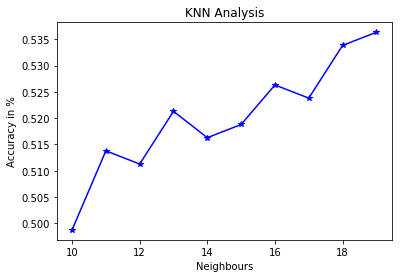

In [13]:
# implementing K_Nearest_neighbour_Classifier
# getting optimal value of K
from sklearn.neighbors import KNeighborsClassifier
def K_Nearest_Neighbour(k,predict):   
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(x,y)
    y_test_predictions = [predict(review,v,clf) for review in X_test]
    return np.mean(y_test_predictions == y_test)

result = [K_Nearest_Neighbour(k,predict1) for k in range(10,20)]
plt.plot(range(10,20),result,marker='*',color='b')
plt.xlabel('Neighbours')
plt.ylabel('Accuracy in %')
plt.title('KNN Analysis')
optimal_K_neighbors = result.index(max(result)) + 10
print("Maximum Accuracy optained by K_Nearest_Neighbour is {:.2f}%".format(max(result)*100))

Maximum Accuracy optained by Logistic_Regression_Classifier is 58.65%


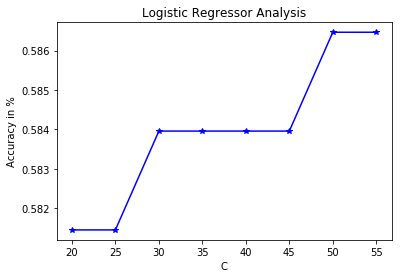

In [14]:
# implementing Logistic_Regression_Classifier
# getting optimal value of C
from sklearn.linear_model import LogisticRegression
def Logistic_Regression_Classifier(c,predict):
    clf = LogisticRegression(C=c)
    clf.fit(x,y)
    y_test_predictions = [predict(review,v,clf) for review in X_test]
    return np.mean(y_test_predictions == y_test)

result = [Logistic_Regression_Classifier(c,predict2) for c in range(20,60,5)]
plt.plot(range(20,60,5),result,marker='*',color='b')
plt.xlabel('C')
plt.ylabel('Accuracy in %')
plt.title('Logistic Regressor Analysis')
optimal_C_LR = result.index(max(result))*5 + 20
print("Maximum Accuracy optained by Logistic_Regression_Classifier is {:.2f}%".format(max(result)*100))

Maximum Accuracy optained by Decision_Tree_Classifier is 42.11%


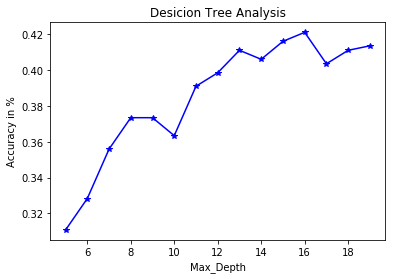

In [15]:
# implementing Decision_Tree_Classifier
# getting optimal value of max_depth
from sklearn.tree import DecisionTreeClassifier
def Decision_Tree_Classifier(d,predict):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(x,y)
    y_test_predictions = [predict(review,v,clf) for review in X_test]
    return np.mean(y_test_predictions == y_test)

result = [Decision_Tree_Classifier(d,predict2) for d in range(5,20)]
plt.plot(range(5,20),result,marker='*',color='b')
plt.xlabel('Max_Depth')
plt.ylabel('Accuracy in %')
plt.title('Desicion Tree Analysis')
optimal_depth = result.index(max(result)) + 1
print("Maximum Accuracy optained by Decision_Tree_Classifier is {:.2f}%".format(max(result)*100))

Maximum Accuracy optained by Decision_Tree_Classifier is 55.39%


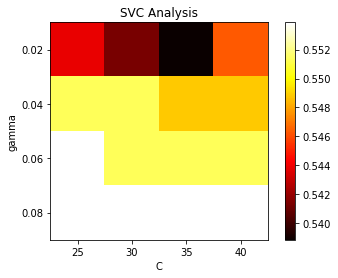

In [16]:
# implementing Support_Vector_Machine_Classifier
# getting optimal value of C,gamma
from sklearn.svm import SVC
def Support_Vector_Machine_Classifier(c,g,predict):
    clf = SVC(kernel='rbf',C=c,gamma=g)
    clf.fit(x,y)
    y_test_predictions = [predict(review,v,clf) for review in X_test]
    return np.mean(y_test_predictions == y_test)

result = []
maxAccuracy,optimal_C_SVC,optimal_gamma = 0,0,0
for g in [0.02,0.04,0.06,0.08]:
    for c in [25,30,35,40]:
        result.append(Support_Vector_Machine_Classifier(c,g,predict2))
        if(result[-1]>maxAccuracy):
            maxAccuracy,optimal_C_SVC,optimal_gamma = result[-1],c,g

plt.imshow(np.array(result).reshape((4,-1)),cmap='hot',interpolation='nearest')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('gamma')
plt.gca().set_xticks(range(4))
plt.gca().set_yticks(range(4))
plt.gca().set_xticklabels([25,30,35,40])
plt.gca().set_yticklabels([0.02,0.04,0.06,0.08])
plt.title('SVC Analysis')
print("Maximum Accuracy optained by Decision_Tree_Classifier is {:.2f}%".format(max(result)*100))

# Making The Optimal Classfiers and Predict Function:

In [17]:
# training optimal classifiers
knn = KNeighborsClassifier(n_neighbors=optimal_K_neighbors).fit(x,y)
lr = LogisticRegression(C=optimal_C_LR).fit(x,y)
dt = DecisionTreeClassifier(max_depth=optimal_depth).fit(x,y)
svc = SVC(kernel='rbf',C=optimal_C_SVC,gamma=optimal_gamma).fit(x,y)

In [18]:
from collections import Counter
def FinalPrediction(review):
    result = [predict1(review,v,knn),predict2(review,v,lr),predict2(review,v,dt),predict2(review,v,svc)]
    cnt = Counter()
    for i in result:
        cnt[i] += 1
    ans = cnt.most_common(3)
    if(ans[0][1]>=3):return ans[0][0]
    if(ans[0][1]==2 and ans[1][1]==1):return ans[0][0]
    cnt[result[0]] += 3
    cnt[result[2]] += 2
    cnt[result[3]] += 1
    return cnt.most_common(1)[0][0]

In [19]:
finalAccuracy = np.mean([FinalPrediction(i) for i in X_test] == y_test)
print("Accuracy of our Training Model is : {:.2f}%".format(finalAccuracy*100))

Accuracy of our Training Model is : 57.89%
